In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Путь до папки с данными
os.chdir('/Users/tony/Desktop/msusums/')

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [3]:
# Фиксируем random_seed (не меняем этот параметр)!
SEED = 42

In [4]:
# Загружаем данные
data = pd.read_csv('train_data.csv')
ans = pd.read_csv('train_ans.csv')
data.shape, ans.shape

((5574703, 3), (57711, 2))

In [5]:
# [1 балл] Разделим данные на обучение и валидацию
# (должно получиться 2 непересекающихся датафрейма)

np.random.seed(SEED)
all_unq_users = np.unique(data.user)
train_users, test_users = np.split(
    np.random.permutation(all_unq_users), [int(len(all_unq_users) * 0.7)]
)

# Ваш код здесь:
train_df = data[data['user'].isin(train_users)]
test_df = data[data['user'].isin(test_users)]

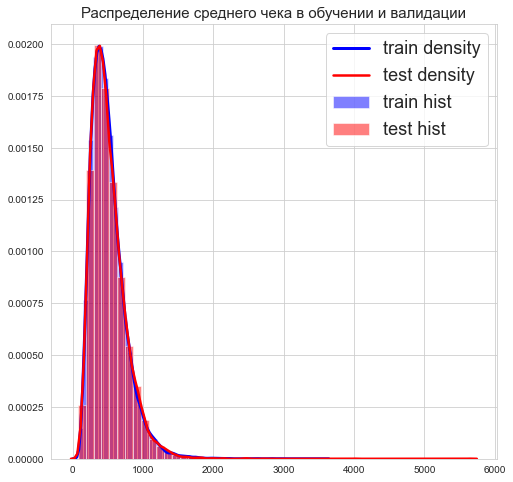

In [6]:
# [1 балл] Проверим, что разделение на обучение и валидацию случайное с точки зрения среднего чека пользователя
# Изобразите плотность распределение среднего чека покупателя для покупателей из обучения и из валидации

# Ваш код здесь:

train_df_no_stubs = train_df[train_df['sum'] != -1]
test_df_no_stubs = test_df[test_df['sum'] != -1]

train_mean = train_df_no_stubs[['user', 'sum']].groupby(['user']).mean().rename(columns={'sum':'mean'})
test_mean = test_df_no_stubs[['user', 'sum']].groupby(['user']).mean().rename(columns={'sum':'mean'})

plt.figure()
plt.hist(train_mean['mean'], bins=50, density=True, color='b', alpha=0.5, label='train hist')
plt.hist(test_mean['mean'], bins=50, density=True, color='r', alpha=0.5, label='test hist')
sns.kdeplot(train_mean['mean'], linewidth=3, color='b', label='train density')
sns.kdeplot(test_mean['mean'], linewidth=2.5, color='r', label='test density')
plt.legend(fontsize=18)
plt.title(u'Распределение среднего чека в обучении и валидации', fontsize=15)
plt.show()

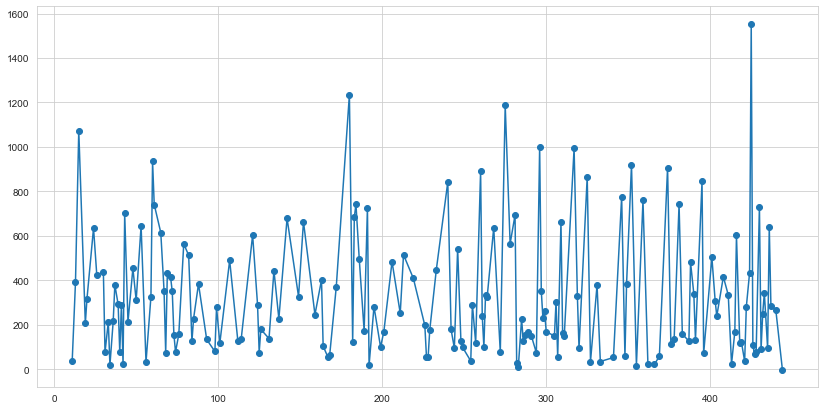

In [7]:
# [1 балл] Изобразите историю сумм покупок для какого-то покупателя
np.random.seed(SEED)
some_user = np.random.choice(all_unq_users)

# Ваш код здесь:
some_user_data = data[data['user'] == some_user]
plt.figure(figsize=(14,7))
plt.plot(some_user_data['day'], some_user_data['sum'], marker='o')
plt.show()

In [8]:
# [2 балла] Реализуйте функцию подсчёта мейпа (MAPE)
# Не забудьте учесть случай нулей в y_true

def mape(y_true: np.array, y_pred: np.array) -> float:
    
    """
    Подсчитывает MAPE по формуле: (1/n) * ∑ |y_true - y_pred| / |y_true|
    
    Args:
        y_true: np.array с истинными значениями таргета
        y_pred: np.array с предсказанными значениями
    Returns:
        MAPE (если в y_true есть нули, то такие наблюдения нужно выкинуть из рассчёта метрики)
    """
    
    # Ваш код здесь:
    
    MAPE = np.mean(np.abs(y_true[y_true != 0] - y_pred[y_true != 0]) / y_true[y_true != 0])
    
    return MAPE

In [9]:
# [2 балла] Сделайте прогноз как среднюю стоимость покупки на истории и посчитайте его точность (MAPE) 
# (на обучении и на валидации)

# Ваш код здесь:

train_true_pred = pd.merge(ans, train_mean, how='inner', left_on=('user'), right_index=True)
test_true_pred = pd.merge(ans, test_mean, how='inner', left_on=('user'), right_index=True)

train_true = np.array(train_true_pred['sum'])
train_pred = np.array(train_true_pred['mean'])

test_true = np.array(test_true_pred['sum'])
test_pred = np.array(test_true_pred['mean'])

print(mape(train_true, train_pred))
print(mape(test_true, test_pred))

2.068884817459657
2.0156428171463454


In [10]:
%%time
# [3 балла] Напишите функцию, которая переводит данные о продажах (такие как в data) в формат, удобный для модели, 
# а именно, вот в такой формат:
    #user   day0     day1    day2     day3  ... target    sum1   sum2    sum3  ...
    #0      438      437     435      433         20      555     3       40
    #1      398      438     437      315         93      104     409     143
    #...
# (числа в примере рандомные). day0 - день, на который нужно предсказать
    

def prepare_X(df: pd.DataFrame, ans: pd.DataFrame=None) -> pd.DataFrame:
    
    """
    Преобразует данные об истории продаж в удобный для модели формат. 
    Обязательно наличие у df колонок "user", "day" и "sum"
    
    Args:
        df - датафрейм с историей продаж
        ans - датафрейм с таргетами (обязательны колонки "user" и "sum"). Если ans не None, то в выходном
            датафрейме должен быть столбец target
    """
    
    # Ваш код здесь:
    days = df.groupby('user')['day'].apply(lambda x: pd.Series(x.values[::-1])).unstack().add_prefix('day')
    sums = df.groupby('user')['sum'].apply(lambda x: pd.Series(x.values[::-1])).unstack().add_prefix('sum')
    
    Xy = pd.merge(days, sums, how='inner', on='user').reset_index().rename(columns={'sum0':'target'})
    
    if ans is not None:
        target = pd.merge(Xy['user'], ans, how='inner', on='user')
        Xy['target'] = target['sum']
    
    return Xy

Xy = prepare_X(df=data, ans=ans)
Xy

Wall time: 26.4 s


,user,day0,day1,day2,day3,day4,day5,day6,day7,day8,...,sum168,sum169,sum170,sum171,sum172,sum173,sum174,sum175,sum176,sum177
0,1,438.0,437.0,433.0,432.0,430.0,423.0,421.0,419.0,417.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,439.0,437.0,435.0,426.0,424.0,419.0,416.0,415.0,412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,439.0,434.0,432.0,425.0,420.0,412.0,404.0,396.0,391.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,432.0,429.0,426.0,423.0,421.0,419.0,416.0,411.0,409.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,434.0,425.0,421.0,418.0,411.0,394.0,381.0,375.0,372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57706,82439,440.0,432.0,413.0,410.0,409.0,404.0,397.0,395.0,394.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57707,82440,444.0,438.0,436.0,434.0,431.0,430.0,428.0,426.0,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57708,82442,441.0,438.0,437.0,432.0,427.0,425.0,420.0,416.0,415.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57709,82443,440.0,438.0,436.0,435.0,432.0,429.0,428.0,426.0,422.0,...,122.0,120.0,723.0,12.0,42.0,NaN,NaN,NaN,NaN,NaN


In [11]:
data

,user,day,sum
0,1,3,1146
1,1,5,71
2,1,6,65
3,1,10,63
4,1,12,31
...,...,...,...
5574698,82444,429,150
5574699,82444,432,500
5574700,82444,434,988
5574701,82444,443,973


In [11]:
# [1 балл] подберите оптимальное (критерий: MAPE) число соседей на валидации для метода KNN, где в качестве прогноза будем брать
# средние траты по k последним дням, в которых были покупки
n_neighbours = []
mapes_train = []
mapes_test = []

# Ваш код здесь:
Xy_train = Xy[Xy['user'].isin(train_users)]
Xy_test = Xy[Xy['user'].isin(test_users)]

for n_neigh in range(177):
    
    n_neighbours.append(n_neigh + 1)
    
    train_pred = np.array(Xy_train.iloc[:, 180:(181 + n_neigh)].mean(axis=1))
    test_pred = np.array(Xy_test.iloc[:, 180:(181 + n_neigh)].mean(axis=1))
    
    mapes_train.append(mape(train_true, train_pred))
    mapes_test.append(mape(test_true, test_pred))
    
    

n_neighbours = np.array(n_neighbours)
mapes_train = np.array(mapes_train)
mapes_test = np.array(mapes_test)

# Оптимальные число соседей и mape для обучения и валидации:
train_mape_opt = mapes_train.min()
test_mape_opt = mapes_test.min()

train_neigh_opt = n_neighbours[np.where(mapes_train == train_mape_opt)[0][0]]
test_neigh_opt = n_neighbours[np.where(mapes_test == test_mape_opt)[0][0]]

print('Число соседей:MAPE\n\nОбучение ' + str(train_neigh_opt) + ' : ' + str(train_mape_opt),
      '\nВалидация ' + str(test_neigh_opt) + ' : ' + str(test_mape_opt))

Число соседей:MAPE

Обучение 27 : 2.005531293696023 
Валидация 35 : 1.9682942211009884


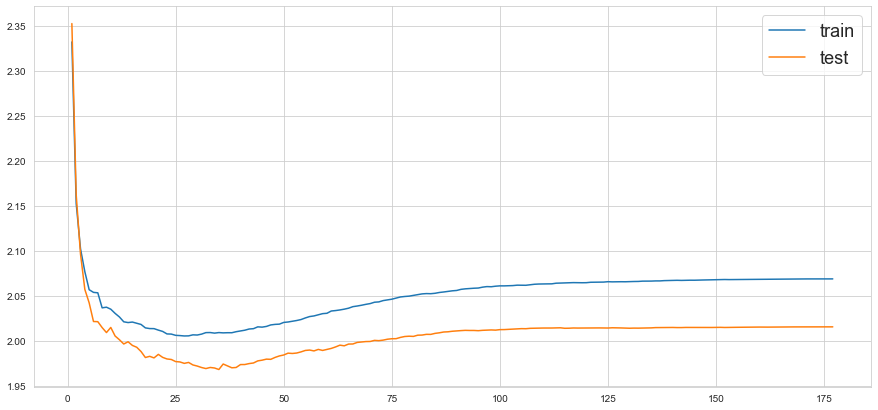

In [12]:
# [1 балл] Изобразите зависимость mapes_train от n_neighbours и mapes_test от n_neighbours

# Ваш код здесь:
plt.figure(figsize=(15,7))
plt.plot(n_neighbours, mapes_train, label='train')
plt.plot(n_neighbours, mapes_test, label='test')
plt.legend(fontsize=18)
plt.show()

### Весовые схемы

Реализуем различные весовые схемы:

1) $\tilde{w_{i}} = \left( \frac{d - i + 1}{d}  \right)^\delta, \ i \in \{1, 2, \dots, d   \}, \ \delta \in [0, +\infty)$

2) $\tilde{w_{i}} = \lambda^i, \ \lambda \in (0, 1]$

3) $\tilde{w_{i}} = \frac{1}{i^\gamma}, \ \gamma \in [0, +\infty)$

Итоговые веса должны быть нормированы: $\sum\limits_{i=1}^d w_{i} = 1$. Для этого просто поделим веса на сумму: $w_{i} = \frac{\tilde{w_{i}}}{\sum\limits_{i=1}^d\tilde{w_{i}}}$

In [11]:
# [3 балла] Реализуйте функции создание весов по схемам, описанным выше
# На выходе веса должны уже быть нормированными

def delta_weights(d: int, delta: float=1.0) -> np.array:
    # Ваш код здесь:
    ww = np.array([((d - (i + 1) + 1) / d) ** delta for i in range(d)])
    wi = ww / ww.sum()
    return wi

def lamb_weights(d: int, lamb: float=1) -> np.array:
    # Ваш код здесь:
    ww = np.array([lamb ** (i + 1) for i in range(d)])
    wi = ww / ww.sum()
    return wi

def gamma_weights(d: int, gamma: float=1) -> np.array:
    # Ваш код здесь:
    ww = np.array([1 / ((i + 1) ** gamma) for i in range(d)])
    wi = ww / ww.sum()
    return wi

In [14]:
%%time
# [1 балл] Подберите оптимальное значение параметра delta для первой весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее

delta_list = []
mapes_train = []
mapes_test = []

# Ваш код здесь:
k = 35

for delta in np.append(np.linspace(0, 1, 101), np.linspace(2, 400, 399)):
    delta_list.append(delta)

    train_pred = Xy_train.loc[:,'sum1':'sum35'].dot(delta_weights(k, delta))
    test_pred = Xy_test.loc[:,'sum1':'sum35'].dot(delta_weights(k, delta))

    mapes_train.append(mape(np.array(Xy_train['target']), train_pred))
    mapes_test.append(mape(np.array(Xy_test['target']), test_pred))

delta_list = np.array(delta_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

# Оптимальные delta и mape для обучения и валидации
train_mape_opt = mapes_train.min()
test_mape_opt = mapes_test.min()

train_delta_opt = delta_list[np.where(mapes_train == train_mape_opt)[0][0]]
test_delta_opt = delta_list[np.where(mapes_test == test_mape_opt)[0][0]]


print('Оптимальное delta : MAPE\n\nОбучение ' + str(train_delta_opt) + ' : ' + str(train_mape_opt),
      '\nВалидация ' + str(test_delta_opt) + ' : ' + str(test_mape_opt))

Оптимальное delta : MAPE

Обучение 0.35000000000000003 : 1.998772018864782 
Валидация 0.0 : 1.9867895567821214
Wall time: 16.1 s


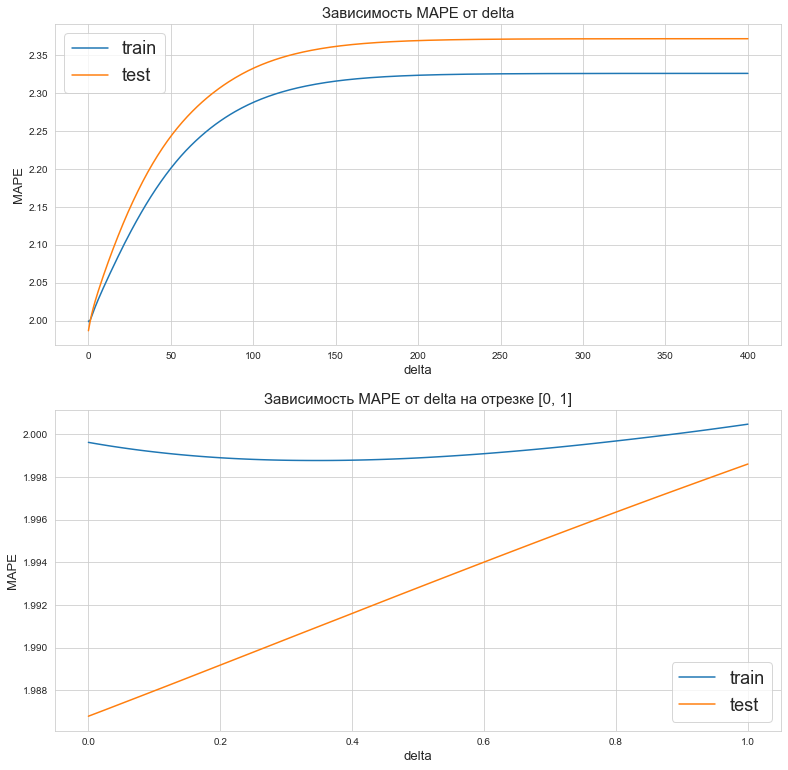

In [15]:
# [1 балл] Изобразите зависимость mapes_train от delta_list и mapes_test от delta_list

# Ваш код здесь:
fig, axes = plt.subplots(2, figsize=(13, 13))

axes[0].plot(delta_list, mapes_train, label='train')
axes[0].plot(delta_list, mapes_test, label='test')
axes[0].legend(fontsize=18)
axes[0].set_xlabel('delta', fontsize=13)
axes[0].set_ylabel('MAPE', fontsize=13)
axes[0].set_title('Зависимость MAPE от delta', fontsize=15)

axes[1].plot(delta_list[:101], mapes_train[:101], label='train')
axes[1].plot(delta_list[:101], mapes_test[:101], label='test')
axes[1].legend(fontsize=18)
axes[1].set_xlabel('delta', fontsize=13)
axes[1].set_ylabel('MAPE', fontsize=13)
axes[1].set_title('Зависимость MAPE от delta на отрезке [0, 1]', fontsize=15)
plt.show()

In [16]:
# [1 балл] Подберите оптимальное значение параметра lamb для второй весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее.

lamb_list = []
mapes_train = []
mapes_test = []

# Ваш код здесь:
k = 35

for lamb in np.linspace(0.001, 1, 1000):
    
    lamb_list.append(lamb)

    train_pred = Xy_train.loc[:,'sum1':'sum35'].dot(lamb_weights(k, lamb))
    test_pred = Xy_test.loc[:,'sum1':'sum35'].dot(lamb_weights(k, lamb))

    mapes_train.append(mape(Xy_train['target'], train_pred))
    mapes_test.append(mape(Xy_test['target'], test_pred))

lamb_list = np.array(lamb_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

# Оптимальные lambda и mape для обучения и валидации
train_mape_opt = mapes_train.min()
test_mape_opt = mapes_test.min()

train_lamb_opt = lamb_list[np.where(mapes_train == train_mape_opt)[0][0]]
test_lamb_opt = lamb_list[np.where(mapes_test == test_mape_opt)[0][0]]


print('Оптимальное lambda : MAPE\n\nОбучение ' + str(train_lamb_opt) + ' : ' + str(train_mape_opt),
      '\nВалидация ' + str(test_lamb_opt) + ' : ' + str(test_mape_opt))

Оптимальное lambda : MAPE

Обучение 0.989 : 1.999451167633991 
Валидация 1.0 : 1.9867895567821214


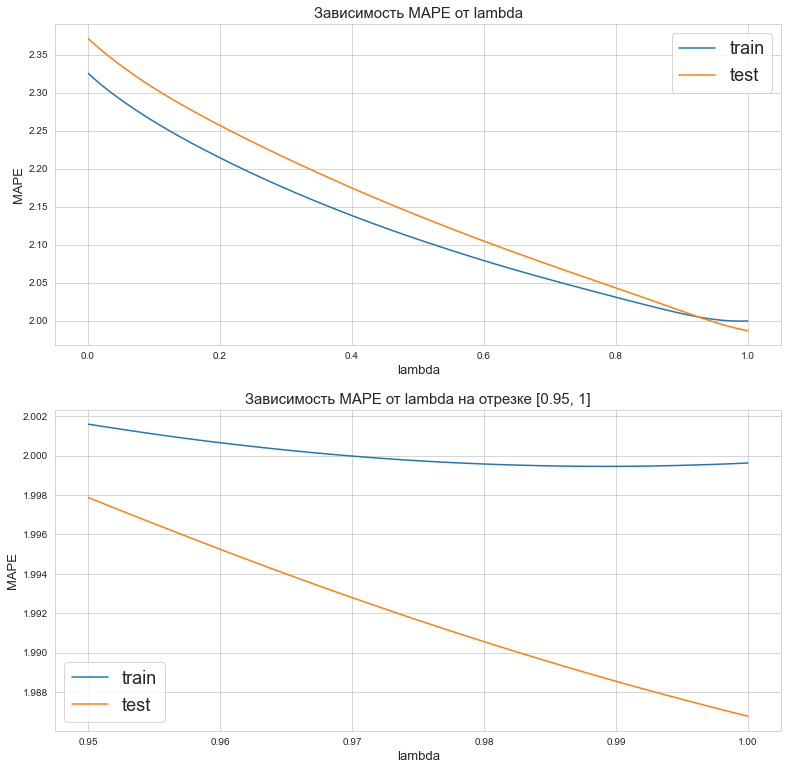

In [17]:
# [1 балл] Изобразите зависимость mapes_train от lamba_list и mapes_test от lamba_list

# Ваш код здесь:
fig, axes = plt.subplots(2, figsize=(13, 13))

axes[0].plot(lamb_list, mapes_train, label='train')
axes[0].plot(lamb_list, mapes_test, label='test')
axes[0].legend(fontsize=18)
axes[0].set_xlabel('lambda', fontsize=13)
axes[0].set_ylabel('MAPE', fontsize=13)
axes[0].set_title('Зависимость MAPE от lambda', fontsize=15)

axes[1].plot(lamb_list[-51:], mapes_train[-51:], label='train')
axes[1].plot(lamb_list[-51:], mapes_test[-51:], label='test')
axes[1].legend(fontsize=18)
axes[1].set_xlabel('lambda', fontsize=13)
axes[1].set_ylabel('MAPE', fontsize=13)
axes[1].set_title('Зависимость MAPE от lambda на отрезке [0.95, 1]', fontsize=15)
plt.show()

In [18]:
# [1 балл] Подберите оптимальное значение параметра gamma для третьей весовой схемы. В качестве числа соседей 
# возьмите оптимальное число, найденное ранее.

gamma_list = []
mapes_train = []
mapes_test = []

# Ваш код здесь:
k = 35

for gamma in np.append(np.linspace(0, 2, 201), np.linspace(3, 50, 96)):
    
    gamma_list.append(gamma)

    train_pred = Xy_train.loc[:,'sum1':'sum35'].dot(gamma_weights(k, gamma))
    test_pred = Xy_test.loc[:,'sum1':'sum35'].dot(gamma_weights(k, gamma))

    mapes_train.append(mape(Xy_train['target'], train_pred))
    mapes_test.append(mape(Xy_test['target'], test_pred))

gamma_list = np.array(gamma_list)
mapes_train = np.array(mapes_train);
mapes_test = np.array(mapes_test);

# Оптимальные gamma и mape для обучения и валидации
train_mape_opt = mapes_train.min()
test_mape_opt = mapes_test.min()

train_gamma_opt = gamma_list[mapes_train == train_mape_opt][0]
test_gamma_opt = gamma_list[mapes_test == test_mape_opt][0]

print('Оптимальное gamma : MAPE\n\nОбучение ' + str(train_gamma_opt) + ' : ' + str(train_mape_opt),
      '\nВалидация ' + str(test_gamma_opt) + ' : ' + str(test_mape_opt))

Оптимальное gamma : MAPE

Обучение 0.0 : 1.9996216557479398 
Валидация 0.0 : 1.9867895567821214


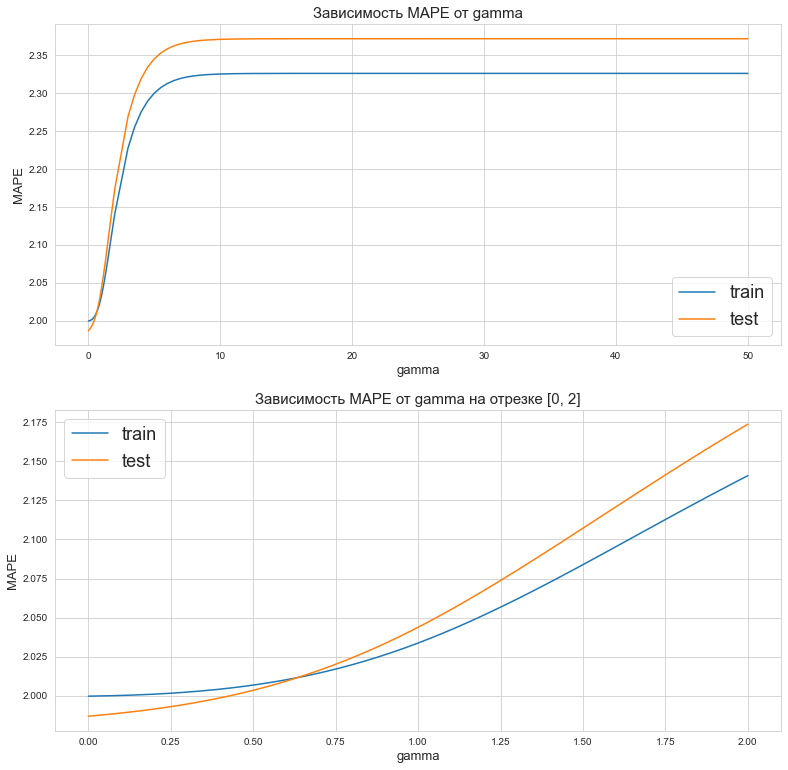

In [19]:
# [1 балл] Изобразите зависимость mapes_train от gamma_list и mapes_test от gamma_list

# Ваш код здесь:
fig, axes = plt.subplots(2, figsize=(13, 13))

axes[0].plot(gamma_list, mapes_train, label='train')
axes[0].plot(gamma_list, mapes_test, label='test')
axes[0].legend(fontsize=18)
axes[0].set_xlabel('gamma', fontsize=13)
axes[0].set_ylabel('MAPE', fontsize=13)
axes[0].set_title('Зависимость MAPE от gamma', fontsize=15)

axes[1].plot(gamma_list[:201], mapes_train[:201], label='train')
axes[1].plot(gamma_list[:201], mapes_test[:201], label='test')
axes[1].legend(fontsize=18)
axes[1].set_xlabel('gamma', fontsize=13)
axes[1].set_ylabel('MAPE', fontsize=13)
axes[1].set_title('Зависимость MAPE от gamma на отрезке [0, 2]', fontsize=15)
plt.show()

### Дополнительные пункты

<ol>
    <li> [3 Балла]
        Попробуйте добавить признаков в модель (День недели, день месяца, номер месяца, расстояние до какой-то даты, ...). Увеличили ли они качество предсказания для Вашей модели?</li>
    <li> [3 Балла] Попробуйте отнестись к признаком дат как к категориальным и сделать для них энкодинги (label encoding, OHE, target encoding, ...). Какая кодировка приводит к наибольшему качеству?</li>
    <li> [4 Балла] В этом пункте у Вас нет ограничения по методикам и моделям - добейтесь максимального качества (минимальный MAPE) на валидации</li>
</ol>

### Получение предсказаний для теста

In [12]:
%%time
# Загружаем данные, для которых хотим получить предсказания
test_data = pd.read_csv('test_data.csv')

Wall time: 369 ms


In [15]:
# [1 балл] Получите предсказания для test_data (лучшей из моделей, которые Вы получили ранее) 
# и сохраните их в файл "test_predictions.csv" в той же папке.

# Ваш код здесь:
Xy_pred = prepare_X(test_data)
test_predictions = np.array(Xy_pred.loc[:,'sum1':'sum35'].dot(delta_weights(35, 0.35)))
pred_csv = pd.DataFrame()
pred_csv['user'] = Xy_pred['user']
pred_csv['sum'] = test_predictions
pred_csv.to_csv('test_predictions.csv', index=False)